<a href="https://colab.research.google.com/github/podobongbong/the_project/blob/main/nov18_multi_var_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
!git clone https://github.com/podobongbong/the_project.git
import os
os.chdir('/content/the_project')
import pandas as pd


Cloning into 'the_project'...
remote: Enumerating objects: 185, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 185 (delta 58), reused 45 (delta 45), pack-reused 109 (from 1)
Receiving objects: 100% (185/185), 6.56 MiB | 12.48 MiB/s, done.
Resolving deltas: 100% (88/88), done.


In [16]:
seoul = pd.read_csv('/content/the_project/data/seoul_04.csv')
busan = pd.read_csv('/content/the_project/data/busan_04.csv')

In [17]:
print(seoul.isnull().sum())  # Check for NaNs in Seoul data
print(busan.isnull().sum())  # Check for NaNs in Busan data


ym                  0
average             0
low                 0
high                0
temp_range          0
high_deviation      0
low_deviation       0
climate_summary     0
energy              0
pop                39
urban_bcr           0
urban_far           0
dtype: int64
ym                  0
average             0
low                 0
high                0
temp_range          0
high_deviation      0
low_deviation       0
climate_summary     0
energy              0
pop                39
urban_bcr           0
urban_far           0
dtype: int64


In [3]:

import tensorflow as tf
import numpy as np
import random
# seed fixing
seed = 786848392
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)


#%% DATA PREP
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Seoul Scalers
scaler_energy_seoul = MinMaxScaler()
scaler_population_seoul = MinMaxScaler()
scaler_climate_seoul = MinMaxScaler()
scaler_urban_bcr_seoul = MinMaxScaler()
scaler_urban_far_seoul = MinMaxScaler()

# Busan Scalers
scaler_energy_busan = MinMaxScaler()
scaler_population_busan = MinMaxScaler()
scaler_climate_busan = MinMaxScaler()
scaler_urban_bcr_busan = MinMaxScaler()
scaler_urban_far_busan = MinMaxScaler()

# Normalize Seoul data (energy, pop, climate)
seoul_energy_scaled = scaler_energy_seoul.fit_transform(seoul['energy'].values.flatten().reshape(-1, 1))
seoul_population_scaled = scaler_population_seoul.fit_transform(seoul['pop'].values.flatten().reshape(-1, 1))
seoul_climate_scaled = scaler_climate_seoul.fit_transform(seoul['climate_summary'].values.flatten().reshape(-1, 1))
seoul_urban_bcr_scaled = scaler_urban_bcr_seoul.fit_transform(seoul['urban_bcr'].values.flatten().reshape(-1, 1))
seoul_urban_far_scaled = scaler_urban_far_seoul.fit_transform(seoul['urban_far'].values.flatten().reshape(-1, 1))

# Normalize Busan data (energy, pop, climate)
busan_energy_scaled = scaler_energy_busan.fit_transform(busan['energy'].values.flatten().reshape(-1, 1))
busan_population_scaled = scaler_population_busan.fit_transform(busan['pop'].values.flatten().reshape(-1, 1))
busan_climate_scaled = scaler_climate_busan.fit_transform(busan['climate_summary'].values.flatten().reshape(-1, 1))
busan_urban_bcr_scaled = scaler_urban_bcr_busan.fit_transform(busan['urban_bcr'].values.flatten().reshape(-1, 1))
busan_urban_far_scaled = scaler_urban_far_busan.fit_transform(busan['urban_far'].values.flatten().reshape(-1, 1))


In [4]:
#%% SLIDING WINDOW
#%% Create Sliding Windows
def create_sliding_window_multi(data_energy, data_population, data_climate, urban_bcr, urban_far, window_size):
    X, y = [], []
    for i in range(window_size, len(data_energy)):
        X.append(np.column_stack((data_energy[i-window_size:i], data_population[i-window_size:i],data_climate[i-window_size:i],
                                  urban_bcr[i-window_size:i],urban_far[i-window_size:i])))
        y.append(data_energy[i])  # Next month's energy consumption
    return np.array(X), np.array(y)

WINDOW_SIZE = 12
feature_number = 5 #energy, population, climate, urban_bcr, urban_far

# Create sliding window samples for Seoul and Busan
X_seoul, y_seoul = create_sliding_window_multi(seoul_energy_scaled, seoul_population_scaled, seoul_climate_scaled, seoul_urban_bcr_scaled, seoul_urban_far_scaled, WINDOW_SIZE)
X_busan, y_busan = create_sliding_window_multi(busan_energy_scaled, busan_population_scaled, busan_climate_scaled, busan_urban_bcr_scaled, busan_urban_far_scaled, WINDOW_SIZE)

# Split Busan data into training and test sets (hold out the last 12 months for testing)
X_train_busan = X_busan[:-12]
y_train_busan = y_busan[:-12]
X_test_busan = X_busan[-12:]
y_test_busan = y_busan[-12:]


In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, BatchNormalization, Reshape
import matplotlib.pyplot as plt

# Basis of the transfer model is LSTM model
## Step 1: Pre-trained Model for Feature Extraction on Seoul's Data
# Building and compiling the pre-trained model
input_layer = Input(shape=(WINDOW_SIZE, feature_number), name='Input')
lstm_out = LSTM(64, activation='tanh', name='LSTM_Layer')(input_layer)
dense_1 = Dense(32, activation='relu', name='Dense_1')(lstm_out)
dense_2 = Dense(16, activation='relu', name='Dense_2')(dense_1)
output_layer = Dense(1, activation='linear', name='Output')(dense_2)

pretrained_model = Model(inputs=input_layer, outputs=output_layer)
pretrained_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Pretrain on Seoul's data
print("Pretraining on Seoul's data...")
history_pretrain = pretrained_model.fit(X_seoul, y_seoul, epochs=100, batch_size=16, validation_split=0.2)

# Check weights before freezing
print("Weights before freezing:")
print(pretrained_model.weights)



Pretraining on Seoul's data...
Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - loss: 0.0746 - mae: 0.2383 - val_loss: nan - val_mae: nan
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0179 - mae: 0.0993 - val_loss: nan - val_mae: nan
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0139 - mae: 0.0780 - val_loss: nan - val_mae: nan
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0135 - mae: 0.0879 - val_loss: nan - val_mae: nan
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0134 - mae: 0.0811 - val_loss: nan - val_mae: nan
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0126 - mae: 0.0806 - val_loss: nan - val_mae: nan
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0127 - mae: 0.0815 - val_loss: nan - val_mae: nan
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0126 - mae: 0.0804 - val_loss: nan - val_mae: nan
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0125 - mae

In [7]:
## Step 3: Freeze the LSTM layer for Feature Extraction

#Option 1: only freezing LSTM Layer
# Freeze the LSTM layer in the pre-trained model for feature extraction
pretrained_model.get_layer('LSTM_Layer').trainable = False

# Confirm frozen layers
print("Layers after freezing:")
for layer in pretrained_model.layers:
    print(layer.name, layer.trainable)

# Create a model for feature extraction from the LSTM layer's output
feature_extractor = Model(inputs=pretrained_model.input, outputs=pretrained_model.get_layer('LSTM_Layer').output)

# Generate extracted features for Busan's training and test data
X_train_features_busan = feature_extractor.predict(X_train_busan)
X_test_features_busan = feature_extractor.predict(X_test_busan)


Layers after freezing:
Input True
LSTM_Layer False
Dense_1 True
Dense_2 True
Output True
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


In [ ]:
## Step 3: Freeze the LSTM layer for Feature Extraction

# Option 2: Freeze the LSTM layer, Dense_1, while keeping Dense_2 trainable
pretrained_model.get_layer('LSTM_Layer').trainable = False
pretrained_model.get_layer('Dense_1').trainable = False
pretrained_model.get_layer('Dense_2').trainable = True  # Keep trainable for flexibility

# Confirm frozen layers
print("Layers after freezing:")
for layer in pretrained_model.layers:
    print(layer.name, layer.trainable)

# Modify feature extractor to output from Dense_2
feature_extractor = Model(inputs=pretrained_model.input, outputs=pretrained_model.get_layer('Dense_2').output)

# Generate extracted features
X_train_features_busan = feature_extractor.predict(X_train_busan)
X_test_features_busan = feature_extractor.predict(X_test_busan)

In [8]:

## Step 4: Build a New Model for Fine-Tuning on Busan's Data
# New model input layer
input_features_layer = Input(shape=(X_train_features_busan.shape[1],), name='Input_Features')
reshaped_input = Reshape((1, X_train_features_busan.shape[1]))(input_features_layer)  # Reshape to (batch_size, time_steps=1, features)

# New LSTM layer for fine-tuning
lstm_new = LSTM(32, activation='tanh', name='LSTM_New')(reshaped_input)

# Add dense layers with batch normalization for better training
dense_new_1 = Dense(32, activation='relu', name='Dense_New_1')(lstm_new)
batch_norm_1 = BatchNormalization(name='Batch_Norm_1')(dense_new_1)
dense_new_2 = Dense(16, activation='relu', name='Dense_New_2')(batch_norm_1)
batch_norm_2 = BatchNormalization(name='Batch_Norm_2')(dense_new_2)

# Final output layer
output_new_layer = Dense(1, activation='linear', name='Output')(batch_norm_2)

# Combine into new model
new_model = Model(inputs=input_features_layer, outputs=output_new_layer)
new_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mse', metrics=['mae'])

# Check initial weights of new model before fine-tuning
print("Initial weights of the new model:")
print(new_model.weights)



Initial weights of the new model:
[<KerasVariable shape=(64, 128), dtype=float32, path=LSTM_New/lstm_cell/kernel>, <KerasVariable shape=(32, 128), dtype=float32, path=LSTM_New/lstm_cell/recurrent_kernel>, <KerasVariable shape=(128,), dtype=float32, path=LSTM_New/lstm_cell/bias>, <KerasVariable shape=(32, 32), dtype=float32, path=Dense_New_1/kernel>, <KerasVariable shape=(32,), dtype=float32, path=Dense_New_1/bias>, <KerasVariable shape=(32,), dtype=float32, path=Batch_Norm_1/gamma>, <KerasVariable shape=(32,), dtype=float32, path=Batch_Norm_1/beta>, <KerasVariable shape=(32,), dtype=float32, path=Batch_Norm_1/moving_mean>, <KerasVariable shape=(32,), dtype=float32, path=Batch_Norm_1/moving_variance>, <KerasVariable shape=(32, 16), dtype=float32, path=Dense_New_2/kernel>, <KerasVariable shape=(16,), dtype=float32, path=Dense_New_2/bias>, <KerasVariable shape=(16,), dtype=float32, path=Batch_Norm_2/gamma>, <KerasVariable shape=(16,), dtype=float32, path=Batch_Norm_2/beta>, <KerasVariable

In [9]:

## Step 5: Train the new model with extracted features for Busan's data
print("Training new layers on Busan's data...")
history_finetune = new_model.fit(X_train_features_busan, y_train_busan, epochs=100, batch_size=32, validation_split=0.2)

# Check weights after fine-tuning
print("Weights after fine-tuning:")
print(new_model.weights)




Training new layers on Busan's data...
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - loss: 4.3145 - mae: 1.6554 - val_loss: nan - val_mae: nan
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.1235 - mae: 1.4208 - val_loss: nan - val_mae: nan
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2.3708 - mae: 1.2449 - val_loss: nan - val_mae: nan
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.8756 - mae: 1.1139 - val_loss: nan - val_mae: nan
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.5349 - mae: 1.0083 - val_loss: nan - val_mae: nan
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.2922 - mae: 0.9196 - val_loss: nan - val_mae: nan
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.1000 - mae: 0.8440 - val_loss: nan - val_mae: nan
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.9475 - mae: 0.7857 - val_loss: nan - val_mae: nan
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - loss: 0.8227 - mae: 0.7319 

Evaluating on Busan's test data...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: nan - mae: nan
Test Loss: nan, Test MAE: nan
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


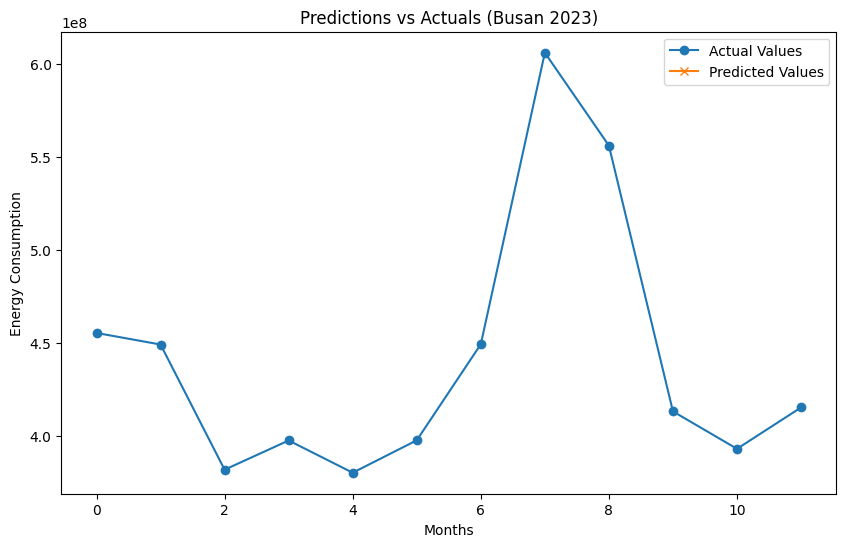

In [10]:

# Step 6: Evaluate and Predict on Busan's Test Data

print("Evaluating on Busan's test data...")
test_loss, test_mae = new_model.evaluate(X_test_features_busan, y_test_busan)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

# Predict on test data
predictions = new_model.predict(X_test_features_busan)

# Rescale predictions and actual values back to the original scale for interpretation
predictions_rescaled = scaler_energy_busan.inverse_transform(predictions.reshape(-1, 1)).flatten()
actual_rescaled = scaler_energy_busan.inverse_transform(y_test_busan.reshape(-1, 1)).flatten()

# Visualization of Prediction Results
def plot_predictions(y_true, y_pred, title='Predictions vs Actuals (Busan 2023)'):
    plt.figure(figsize=(10, 6))
    plt.plot(y_true, label='Actual Values', marker='o')
    plt.plot(y_pred, label='Predicted Values', marker='x')
    plt.title(title)
    plt.xlabel('Months')
    plt.ylabel('Energy Consumption')
    plt.legend()
    plt.show()

plot_predictions(actual_rescaled, predictions_rescaled)

In [ ]:

epochs = range(1, len(history_finetune.history['loss']) + 1)

# Loss
plt.figure(figsize=(12, 5))
plt.plot(epochs, history_finetune.history['loss'], label='Train Loss')
plt.plot(epochs, history_finetune.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train Loss', 'Validation Loss'])
plt.title('Training and Validation Loss over Epochs')
plt.show()

# MAE
plt.figure(figsize=(12, 5))
plt.plot(epochs, history_finetune.history['mae'], label='Train MAE')
plt.plot(epochs, history_finetune.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend(['Train MAE', 'Validation MAE'])
plt.title('Training and Validation MAE over Epochs')
plt.show()


In [ ]:
save_path = "./transfer_LSTM_hybrid_model.h5"
new_model.save(save_path)
print("Model saved at:", save_path)
